In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('drive')

# --- Unzip the Dataset ---
# Path to the zip file in your Google Drive
zip_path = 'dataset.zip'
# Directory where you want to extract the files
extract_path = '/content/dataset'

# Create directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset successfully unzipped.")

# --- Define Paths ---
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
Dataset successfully unzipped.


In [ ]:
# --- Image Data Generators ---
# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 48, 48
BATCH_SIZE = 64

# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an ImageDataGenerator for the test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Get class indices to map predictions back to labels
class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)
num_classes = len(class_labels)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Class Labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# --- Build the CNN Model ---
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flattening and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Softmax for multi-class classification
])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,491,335 (13.32 MB)

 Trainable params: 3,489,095 (13.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [ ]:
# --- Compile and Train the Model ---

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
# Save the best model
checkpoint = ModelCheckpoint(
    'emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# Stop training if validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50, # You can increase epochs for better performance
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2013 - loss: 2.3113
Epoch 1: val_accuracy improved from -inf to 0.23730, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 55s 85ms/step - accuracy: 0.2013 - loss: 2.3108 - val_accuracy: 0.2373 - val_loss: 2.3094
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.3125 - loss: 1.7392

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.23730
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3125 - loss: 1.7392 - val_accuracy: 0.2365 - val_loss: 2.3249
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2525 - loss: 1.8585
Epoch 3: val_accuracy improved from 0.23730 to 0.29953, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.2526 - loss: 1.8584 - val_accuracy: 0.2995 - val_loss: 1.7457
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.3125 - loss: 1.8379
Epoch 4: val_accuracy improved from 0.29953 to 0.30050, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3125 - loss: 1.8379 - val_accuracy: 0.3005 - val_loss: 1.7445
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2981 - loss: 1.7338
Epoch 5: val_accuracy improved from 0.30050 to 0.38253, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 67s 63ms/step - accuracy: 0.2981 - loss: 1.7337 - val_accuracy: 0.3825 - val_loss: 1.5480
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4375 - loss: 1.5916
Epoch 6: val_accuracy did not improve from 0.38253
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4375 - loss: 1.5916 - val_accuracy: 0.3813 - val_loss: 1.5522
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3878 - loss: 1.5660
Epoch 7: val_accuracy improved from 0.38253 to 0.49191, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.3879 - loss: 1.5659 - val_accuracy: 0.4919 - val_loss: 1.3358
Epoch 8/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.4688 - loss: 1.3958
Epoch 8: val_accuracy did not improve from 0.49191
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4688 - loss: 1.3958 - val_accuracy: 0.4914 - val_loss: 1.3329
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4476 - loss: 1.4386
Epoch 9: val_accuracy improved from 0.49191 to 0.51186, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.4476 - loss: 1.4385 - val_accuracy: 0.5119 - val_loss: 1.2807
Epoch 10/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5312 - loss: 1.2391
Epoch 10: val_accuracy improved from 0.51186 to 0.51772, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5312 - loss: 1.2391 - val_accuracy: 0.5177 - val_loss: 1.2672
Epoch 11/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4850 - loss: 1.3525
Epoch 11: val_accuracy did not improve from 0.51772
448/448 ━━━━━━━━━━━━━━━━━━━━ 35s 61ms/step - accuracy: 0.4850 - loss: 1.3525 - val_accuracy: 0.5093 - val_loss: 1.2887
Epoch 12/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.4844 - loss: 1.1708
Epoch 12: val_accuracy did not improve from 0.51772
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4844 - loss: 1.1708 - val_accuracy: 0.5088 - val_loss: 1.2883
Epoch 13/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5102 - loss: 1.2873
Epoch 13: val_accuracy improved from 0.51772 to 0.52706, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.5103 - loss: 1.2873 - val_accuracy: 0.5271 - val_loss: 1.2296
Epoch 14/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4375 - loss: 1.4381
Epoch 14: val_accuracy improved from 0.52706 to 0.52846, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4375 - loss: 1.4381 - val_accuracy: 0.5285 - val_loss: 1.2254
Epoch 15/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5288 - loss: 1.2427
Epoch 15: val_accuracy did not improve from 0.52846
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5288 - loss: 1.2427 - val_accuracy: 0.5205 - val_loss: 1.2968
Epoch 16/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.6562 - loss: 1.0413
Epoch 16: val_accuracy did not improve from 0.52846
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6562 - loss: 1.0413 - val_accuracy: 0.5223 - val_loss: 1.2897
Epoch 17/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5371 - loss: 1.2191
Epoch 17: val_accuracy did not improve from 0.52846
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.5371 - loss: 1.2191 - val_accuracy: 0.5254 - val_loss: 1.2777
Epoch 18/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.3750 - loss: 1.5831
Epoch 18: val_accu

448/448 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.5450 - loss: 1.2068 - val_accuracy: 0.5725 - val_loss: 1.1307
Epoch 20/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.6250 - loss: 1.0065
Epoch 20: val_accuracy did not improve from 0.57254
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6250 - loss: 1.0065 - val_accuracy: 0.5721 - val_loss: 1.1300
Epoch 21/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5648 - loss: 1.1584
Epoch 21: val_accuracy did not improve from 0.57254
448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.5648 - loss: 1.1584 - val_accuracy: 0.5696 - val_loss: 1.1469
Epoch 22/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4219 - loss: 1.3328
Epoch 22: val_accuracy did not improve from 0.57254
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4219 - loss: 1.3328 - val_accuracy: 0.5705 - val_loss: 1.1414
Epoch 23/50
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5681 - loss: 1.1539
Epoch 23: val_accu

448/448 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.5642 - loss: 1.1521 - val_accuracy: 0.6016 - val_loss: 1.0974
Epoch 26/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6406 - loss: 1.0308
Epoch 26: val_accuracy improved from 0.60156 to 0.60212, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6406 - loss: 1.0308 - val_accuracy: 0.6021 - val_loss: 1.0887
Epoch 27/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5796 - loss: 1.1207
Epoch 27: val_accuracy did not improve from 0.60212
448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.5796 - loss: 1.1208 - val_accuracy: 0.6013 - val_loss: 1.0519
Epoch 28/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6875 - loss: 0.9461
Epoch 28: val_accuracy improved from 0.60212 to 0.60547, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6875 - loss: 0.9461 - val_accuracy: 0.6055 - val_loss: 1.0509
Epoch 29/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5820 - loss: 1.1134
Epoch 29: val_accuracy did not improve from 0.60547
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.5820 - loss: 1.1134 - val_accuracy: 0.5911 - val_loss: 1.1065
Epoch 30/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6562 - loss: 0.9315
Epoch 30: val_accuracy did not improve from 0.60547
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6562 - loss: 0.9315 - val_accuracy: 0.5893 - val_loss: 1.1090
Epoch 31/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5846 - loss: 1.0950
Epoch 31: val_accuracy did not improve from 0.60547
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.5846 - loss: 1.0950 - val_accuracy: 0.5836 - val_loss: 1.1183
Epoch 32/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.5469 - loss: 1.2452
Epoch 32: val_accu

448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.5832 - loss: 1.0970 - val_accuracy: 0.6070 - val_loss: 1.0551
Epoch 34/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7344 - loss: 0.8509
Epoch 34: val_accuracy improved from 0.60700 to 0.60756, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7344 - loss: 0.8509 - val_accuracy: 0.6076 - val_loss: 1.0560
Epoch 35/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6032 - loss: 1.0698
Epoch 35: val_accuracy did not improve from 0.60756
448/448 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - accuracy: 0.6031 - loss: 1.0698 - val_accuracy: 0.6049 - val_loss: 1.0309
Epoch 36/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4844 - loss: 1.1273
Epoch 36: val_accuracy improved from 0.60756 to 0.60868, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4844 - loss: 1.1273 - val_accuracy: 0.6087 - val_loss: 1.0263
Epoch 37/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6039 - loss: 1.0693
Epoch 37: val_accuracy improved from 0.60868 to 0.62151, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.6039 - loss: 1.0693 - val_accuracy: 0.6215 - val_loss: 1.0079
Epoch 38/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.6094 - loss: 1.0443
Epoch 38: val_accuracy improved from 0.62151 to 0.62263, saving model to emotion_model.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6094 - loss: 1.0443 - val_accuracy: 0.6226 - val_loss: 1.0095
Epoch 39/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5984 - loss: 1.0679
Epoch 39: val_accuracy did not improve from 0.62263
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.5984 - loss: 1.0679 - val_accuracy: 0.6076 - val_loss: 1.0592
Epoch 40/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6094 - loss: 1.1023
Epoch 40: val_accuracy did not improve from 0.62263
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6094 - loss: 1.1023 - val_accuracy: 0.6055 - val_loss: 1.0608
Epoch 41/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6068 - loss: 1.0556
Epoch 41: val_accuracy did not improve from 0.62263
448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.6068 - loss: 1.0556 - val_accuracy: 0.5819 - val_loss: 1.1885
Epoch 42/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.6562 - loss: 1.0194
Epoch 42: val_accu

448/448 ━━━━━━━━━━━━━━━━━━━━ 64s 62ms/step - accuracy: 0.6100 - loss: 1.0335 - val_accuracy: 0.6279 - val_loss: 1.0279
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 37.


113/113 - 3s - 29ms/step - accuracy: 0.6220 - loss: 1.0067

Test accuracy: 62.20%


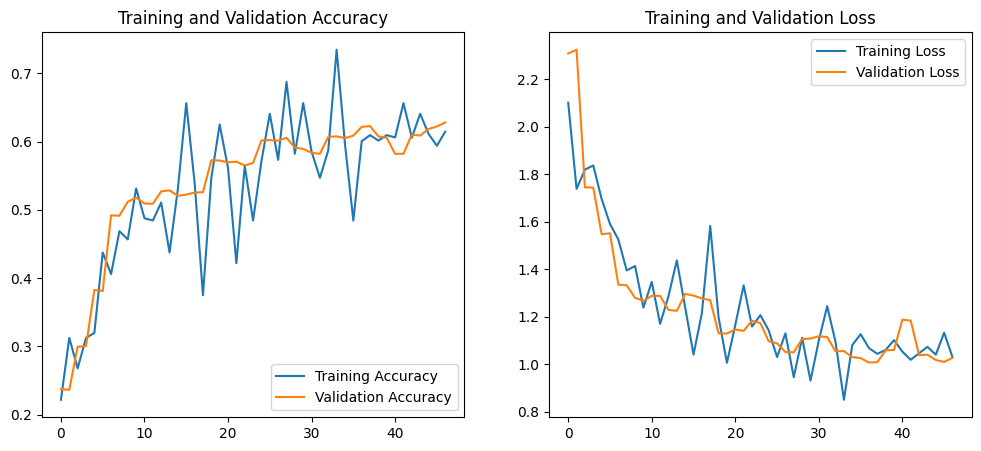

In [ ]:
# --- Evaluate the Model ---

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

# --- Plot Training History ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [3]:
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('emotion_model.h5')

# Download the Haar Cascade file for face detection
if not os.path.exists('haarcascade_frontalface_default.xml'):
    !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define the emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# --- Upload and Process an Image ---
print("Please upload an image to test:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Read the image
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

if len(faces) == 0:
    print("Error: No face detected.")
else:
    # Use the first face detected
    (x, y, w, h) = faces[0]

    # Preprocess the face for the model
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)
    roi = roi_gray.astype('float') / 255.0
    roi = np.expand_dims(np.expand_dims(roi, -1), 0)

    # Predict the emotion
    prediction = model.predict(roi)[0]
    predicted_emotion = emotion_labels[np.argmax(prediction)]

    # Draw the results on the image
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(img, predicted_emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the final image
    print(f"\nPredicted Emotion: {predicted_emotion}")
    cv2_imshow(img)

Please upload an image to test:


Saving PrivateTest_4156626.jpg to PrivateTest_4156626.jpg
Error: No face detected.


In [5]:
from tensorflow.keras.models import load_model # <-- ADD THIS LINE
from google.colab import output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from base64 import b64decode
import numpy as np
import cv2
import os

# --- Load the Trained Model and Face Detector ---
model = load_model('emotion_model.h5')
if not os.path.exists('haarcascade_frontalface_default.xml'):
    !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# --- JavaScript to handle the video stream ---
def video_stream():
  js = Javascript('''
    var video;
    var stream;
    var captureCanvas;
    var shutdown = false;

    function removeDom() {
      if (stream) {
        stream.getTracks().forEach(track => track.stop());
      }
      if (video) video.remove();
      if (captureCanvas) captureCanvas.remove();
    }

    async function videoLoop() {
      if (shutdown) {
        removeDom();
        return;
      }
      var context = captureCanvas.getContext('2d');
      context.drawImage(video, 0, 0, 640, 480);
      var data = captureCanvas.toDataURL('image/jpeg', 0.8);
      var b64 = data.substring(data.indexOf(',') + 1);
      google.colab.kernel.invokeFunction('notebook.run_prediction', [b64], {});
      window.requestAnimationFrame(videoLoop);
    }

    async function start() {
      video = document.createElement('video');
      video.style.display = 'none';
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.style.display = 'block';
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      document.body.appendChild(captureCanvas);
      window.requestAnimationFrame(videoLoop);
    }
    function shutdown_stream() {
      shutdown = true;
    }
    start();
  ''')
  display(js)

# --- Python function to process each frame ---
frame_counter = 0
def run_prediction(img_b64):
    global frame_counter

    # LAG REDUCTION: Only process every 3rd frame
    if frame_counter % 3 == 0:
        jpeg = b64decode(img_b64)
        img_arr = np.frombuffer(jpeg, dtype=np.uint8)
        frame = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

        for (x, y, w, h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (48, 48))
            roi = roi_gray.astype('float') / 255.0
            roi = np.expand_dims(np.expand_dims(roi, -1), 0)

            prediction = model.predict(roi, verbose=0)[0]

            predicted_emotion = emotion_labels[np.argmax(prediction)]
            confidence_score = np.max(prediction)

            label_with_score = f"{predicted_emotion} ({confidence_score*100:.0f}%)"

            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(frame, label_with_score, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2_imshow(frame)

    frame_counter += 1

# --- Start the webcam ---
output.register_callback('notebook.run_prediction', run_prediction)
print("Starting webcam... Please allow camera access in your browser. 📷")
video_stream()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
from tensorflow.keras.models import load_model
from google.colab import output
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from base64 import b64decode
import numpy as np
import cv2
import os

# --- Load the Trained Model and Face Detector ---
model = load_model('emotion_model.h5')
if not os.path.exists('haarcascade_frontalface_default.xml'):
    !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# --- Python function to process the captured image ---
def detect_emotion_on_capture(img_b64):
    # Decode the image from base64
    jpeg = b64decode(img_b64)
    img_arr = np.frombuffer(jpeg, dtype=np.uint8)
    frame = cv2.imdecode(img_arr, cv2.IMREAD_COLOR)

    # Convert to grayscale and detect faces
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("Capture failed: No face was detected.")
        cv2_imshow(frame) # Show the failed capture anyway
    else:
        # Process the first detected face
        (x, y, w, h) = faces[0]

        # Preprocess the face for the model
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi = roi_gray.astype('float') / 255.0
        roi = np.expand_dims(np.expand_dims(roi, -1), 0)

        # Make a prediction
        prediction = model.predict(roi, verbose=0)[0]

        # Get emotion label and confidence score
        predicted_emotion = emotion_labels[np.argmax(prediction)]
        confidence_score = np.max(prediction)
        label_with_score = f"{predicted_emotion} ({confidence_score*100:.0f}%)"

        # Draw results on the frame
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(frame, label_with_score, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Display the final image with the prediction
        print(f"Detected Emotion: {predicted_emotion}")
        cv2_imshow(frame)

# Register the Python function as a callback
output.register_callback('notebook.detect_emotion_on_capture', detect_emotion_on_capture)

# --- JavaScript to create the UI (video feed and button) ---
def capture_photo_ui():
  js = Javascript('''
    var video;
    var stream;
    var captureCanvas;
    var shutdown = false;

    function removeDom() {
      if (stream) {
        stream.getTracks().forEach(track => track.stop());
      }
      // Remove all elements created by this cell
      const elements = document.getElementsByClassName('capture-cell');
      while (elements.length > 0) {
        elements[0].parentNode.removeChild(elements[0]);
      }
    }

    function shutdown_stream() {
      shutdown = true;
      removeDom();
    }

    async function start() {
      if (shutdown) return;

      // Create a container div
      let div = document.createElement('div');
      div.className = 'capture-cell';
      document.body.appendChild(div);

      // Create video element
      video = document.createElement('video');
      video.style.display = 'block';
      video.className = 'capture-cell';
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Create a canvas for capturing frames
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;

      // Create the capture button
      let button = document.createElement('button');
      button.textContent = 'Capture and Detect';
      button.className = 'capture-cell';
      button.style.marginTop = '10px';
      button.style.padding = '10px';
      div.appendChild(button);

      // Button click handler
      button.onclick = () => {
        var context = captureCanvas.getContext('2d');
        context.drawImage(video, 0, 0, 640, 480);
        var data = captureCanvas.toDataURL('image/jpeg', 0.8);
        var b64 = data.substring(data.indexOf(',') + 1);
        console.log("Image captured, sending to Python...");
        google.colab.kernel.invokeFunction('notebook.detect_emotion_on_capture', [b64], {});
      };
    }

    // Make shutdown function globally accessible
    window.shutdown_stream = shutdown_stream;
    start();
  ''')
  display(js)

# --- Start the UI ---
print("Starting webcam... Please allow camera access. 📷")
capture_photo_ui()

Output hidden; open in https://colab.research.google.com to view.